# HDA - Project 3
## TASK B1: Activity detection
This task consists of a binary classification, where a gesture denotes activity and thus the model detects wheter there is a gesture label or not (labeled in column 6).

This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: index of feature column to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [1]:
subject = 2
folder = "./data/full/"
label_col = 6     # 6 is default for task B1
window_size = 15
stride = 3
make_binary = True

In [2]:
import utils
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using TensorFlow backend.


Creation of training set and test set

In [3]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)

# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# make the problem binary
if make_binary:
    Y_train[Y_train != 0] = 1
    Y_test[Y_test != 0] = 1

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])


Session shapes:
ADL1:   (38733, 110)
ADL2:   (26824, 110)
ADL3:   (31242, 110)
ADL4:   (29723, 110)
ADL5:   (27997, 110)
Drill:  (49009, 110)

Training samples:  145808 
Test samples:       57720 
Features:             110

Classes in training set:  2 
Classes in test set:      2


Preparation of data in a input-suitable form

In [4]:
print("Training set:")
X_train_s, Y_train_s = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print("\nTest set:")
X_test_s, Y_test_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)

Training set:
<class 'numpy.ndarray'> (48598, 15, 110) <class 'numpy.ndarray'> (48598, 2)

Features have shape:  (48598, 15, 110) 
Labels have shape:    (48598, 2) 
Fraction of labels:   [0.6279065 0.3720935]

Test set:
<class 'numpy.ndarray'> (19235, 15, 110) <class 'numpy.ndarray'> (19235, 2)

Features have shape:  (19235, 15, 110) 
Labels have shape:    (19235, 2) 
Fraction of labels:   [0.84075903 0.15924097]


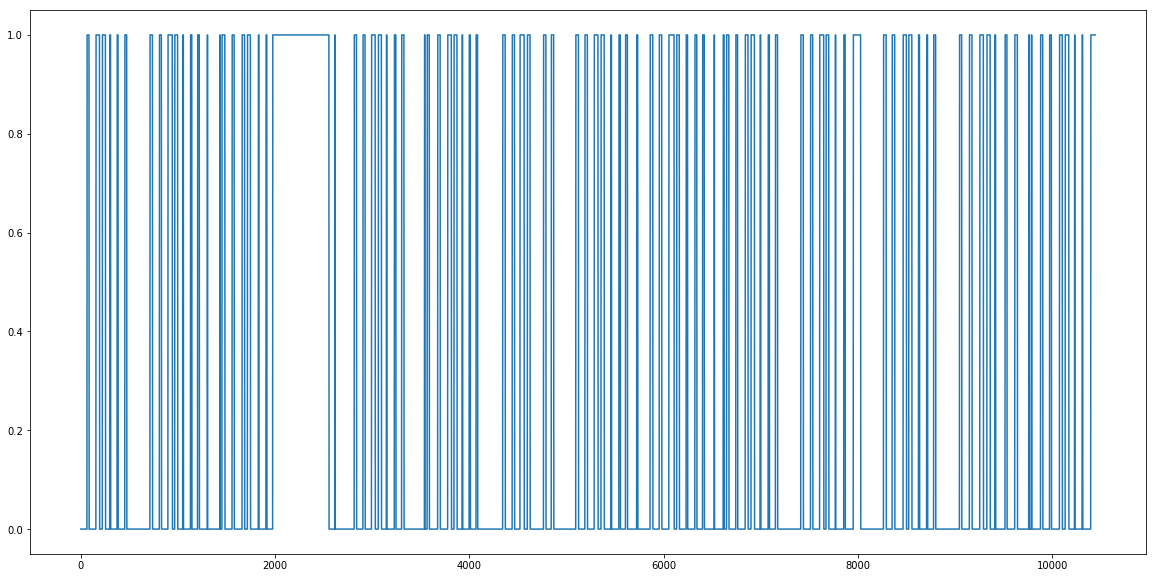

In [5]:
plt.figure(figsize=(20,10))
plt.plot(Y_train_s[-10442:,0])

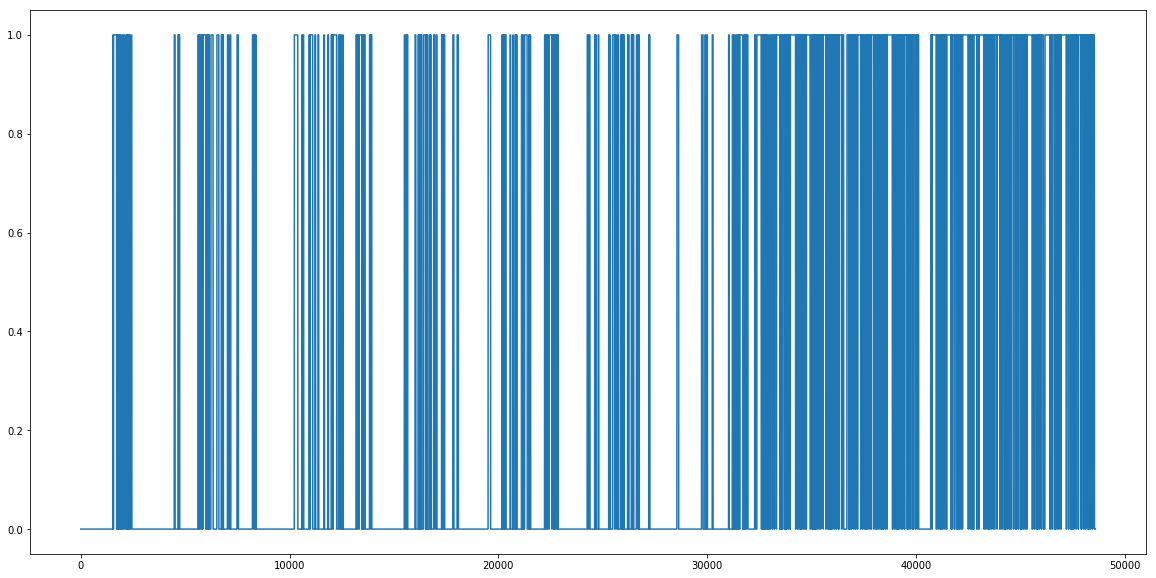

In [6]:
plt.figure(figsize=(20,10))
plt.plot(Y_train_s[:,1])

In [7]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

In [8]:
model_unidim = utils.Model1D((window_size, features), classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 15, 18)            9918      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 18)            72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 18)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 18)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 36)             4572      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 36)             144       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 36)             0         
__________

In [9]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 50, batch_size = 128, validation_data=(X_test_s, Y_test_s))

Train on 48598 samples, validate on 19235 samples
Epoch 1/50
48598/48598 [==============================] - 9s 192us/step - loss: 0.5938 - acc: 0.7353 - val_loss: 0.4215 - val_acc: 0.8252
Epoch 2/50
48598/48598 [==============================] - 5s 113us/step - loss: 0.4956 - acc: 0.7635 - val_loss: 0.3958 - val_acc: 0.8455
Epoch 3/50
48598/48598 [==============================] - 6s 115us/step - loss: 0.4658 - acc: 0.7921 - val_loss: 0.3315 - val_acc: 0.8565
Epoch 4/50
48598/48598 [==============================] - 6s 113us/step - loss: 0.4492 - acc: 0.8026 - val_loss: 0.3625 - val_acc: 0.8476
Epoch 5/50
48598/48598 [==============================] - 6s 115us/step - loss: 0.4341 - acc: 0.8098 - val_loss: 0.3316 - val_acc: 0.8553
Epoch 6/50
48598/48598 [==============================] - 6s 115us/step - loss: 0.4280 - acc: 0.8153 - val_loss: 0.3315 - val_acc: 0.8589
Epoch 7/50
48598/48598 [==============================] - 6s 114us/step - loss: 0.4186 - acc: 0.8187 - val_loss: 0.3671 - 

In [10]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

F1-measure:  0.862138460034361
Class  0 :  AUC =  0.8738639005486966
Class  1 :  AUC =  0.8738640519572933
Average AUC:  0.873863976252995


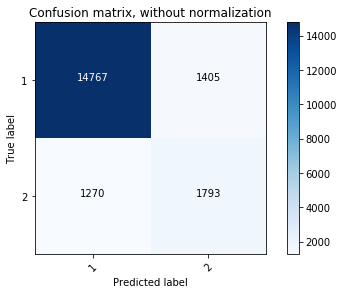

In [11]:
# print results
#reverse the one-hot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
utils.AUC(Y_test_s, Y_pred_s, classes)

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2],
                      title='Confusion matrix, without normalization')

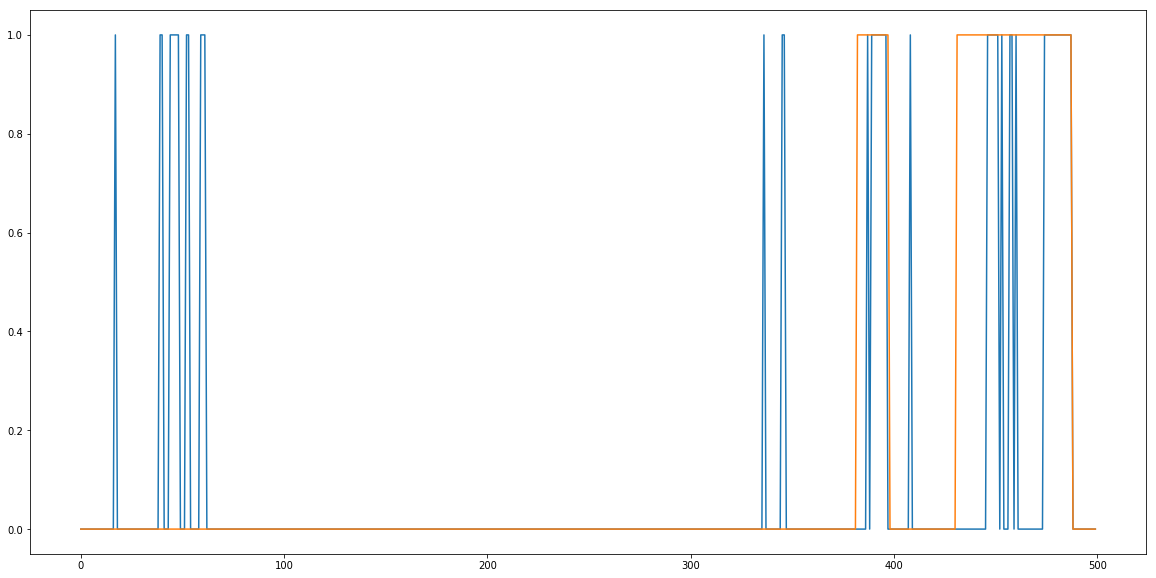

In [12]:
plt.figure(figsize=(20,10))
plt.plot(Y_pred_hard[0:500])
plt.plot(Y_test_hard[0:500])

In [13]:
# revert one hot encoded windowed predicted labels to the unwindowed version
test_labels = utils.unwindowLabels(Y_test_s, window_size, stride)

## Task B2: gesture recognition
This task consists of a 17-class classification, where gestures are labeled in column 6.

To tune the following parameters, refer to the first cell of task B1:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: index of feature column to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

Here we just need to preserve the different labels, thus we set 'make_binary' to False. We have then 18 different labels, keeping into account the null class, with label 0.

In [14]:
make_binary = False

In [15]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)

# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# make the problem binary
if make_binary:
    Y_train[Y_train != 0] = 1
    Y_test[Y_test != 0] = 1

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])


Session shapes:
ADL1:   (38733, 110)
ADL2:   (26824, 110)
ADL3:   (31242, 110)
ADL4:   (29723, 110)
ADL5:   (27997, 110)
Drill:  (49009, 110)

Training samples:  145808 
Test samples:       57720 
Features:             110

Classes in training set:  18 
Classes in test set:      18


In [16]:
print("Training set:")
X_train_s, Y_train_s = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False, null_class=False)
print("\nTest set:")
X_test_s, Y_test_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False, null_class=False)
# add bars plot

Training set:
<class 'numpy.ndarray'> (18038, 15, 110) <class 'numpy.ndarray'> (18038, 17)

Features have shape:  (18038, 15, 110) 
Labels have shape:    (18038, 17) 
Fraction of labels:   [0.05 0.04 0.02 0.05 0.06 0.03 0.06 0.05 0.06 0.03 0.03 0.05 0.05 0.04
 0.07 0.22 0.09]

Test set:
<class 'numpy.ndarray'> (3061, 15, 110) <class 'numpy.ndarray'> (3061, 17)

Features have shape:  (3061, 15, 110) 
Labels have shape:    (3061, 17) 
Fraction of labels:   [0.06 0.04 0.02 0.03 0.06 0.02 0.11 0.06 0.08 0.04 0.03 0.03 0.06 0.03
 0.14 0.1  0.09]


In [17]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

In [ ]:
model_unidim = utils.Model1D((window_size, features), classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 15, 18)            9918      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 18)            72        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 15, 18)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 18)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 36)             4572      
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 36)             144       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 36)             0         
__________

In [ ]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 50, batch_size = 128, validation_data=(X_test_s, Y_test_s))

Train on 18038 samples, validate on 3061 samples
Epoch 1/50
18038/18038 [==============================] - 3s 177us/step - loss: 2.0500 - acc: 0.4088 - val_loss: 2.5664 - val_acc: 0.2486
Epoch 2/50
18038/18038 [==============================] - 2s 105us/step - loss: 1.5692 - acc: 0.5038 - val_loss: 2.3077 - val_acc: 0.3006
Epoch 3/50
18038/18038 [==============================] - 2s 107us/step - loss: 1.4467 - acc: 0.5451 - val_loss: 2.3771 - val_acc: 0.3077
Epoch 4/50
18038/18038 [==============================] - 2s 107us/step - loss: 1.3590 - acc: 0.5653 - val_loss: 2.2646 - val_acc: 0.3172
Epoch 5/50
18038/18038 [==============================] - 2s 107us/step - loss: 1.3198 - acc: 0.5782 - val_loss: 2.4549 - val_acc: 0.2574
Epoch 6/50
18038/18038 [==============================] - 2s 107us/step - loss: 1.2893 - acc: 0.5924 - val_loss: 2.3579 - val_acc: 0.3162
Epoch 7/50
18038/18038 [==============================] - 2s 107us/step - loss: 1.2438 - acc: 0.6014 - val_loss: 2.4859 - v

In [ ]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

In [ ]:
# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
utils.AUC(Y_test_s, Y_pred_s, classes)

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2],
                      title='Confusion matrix, without normalization')

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(Y_pred_hard)
plt.plot(Y_test_hard)